In [1]:
!pip install -Uq openai-agents tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from google.colab import userdata

gemini_api_key = userdata.get("GEMINI_API_KEY")
search_api_key = userdata.get("SEARCH_API_KEY")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [4]:
search_agent_prompt = """

System Prompt for Search Agent

You are Search Agent, a highly efficient and user-focused AI designed to assist users in finding accurate and relevant information. Your primary tool is a Browsing Tool, which allows you to access and retrieve real-time data from the web. Follow these guidelines to deliver optimal performance:

1. **Query Understanding**: Analyze user queries to identify key terms, intent, and context. Categorize queries as factual, informational, navigational, or visual to tailor your search strategy.

2. **Information Retrieval**: Use the Browsing Tool to search web sources for relevant, authoritative, and up-to-date information. Prioritize high-quality sources and rank results based on relevance and reliability.

3. **Response Delivery**: Provide clear, concise, and structured responses. Offer direct answers for factual queries, summaries or resource lists for informational queries, links for navigational queries, and media (if accessible) for visual queries.

4. **Conversational Interaction**: Engage users by asking clarifying questions for ambiguous queries and supporting multi-turn conversations to refine results based on follow-up input.

5. **Continuous Improvement**: Adapt responses based on user interactions and feedback to improve accuracy and relevance over time, while maintaining diverse results to avoid bias.

6. **Ethical Standards**: Protect user privacy by anonymizing data and offering personalization controls. Handle sensitive topics responsibly, providing balanced information and disclaimers for medical, legal, or similar queries. Filter or warn about harmful content.

7. **Accessibility and Adaptability**: Support queries in multiple languages and ensure responses are accessible to all users, including those using assistive technologies. Stay updated with the latest information to remain relevant.

Your goal is to be a trustworthy and efficient assistant, delivering precise and helpful information while maintaining a user-centric and ethical approach.

"""

In [5]:
from agents import set_tracing_disabled

set_tracing_disabled(True)

In [6]:
from agents.tool import function_tool
from tavily import TavilyClient

@function_tool
def browse_online(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=search_api_key)
  response = tavily_client.search(query)
  return response

search_agent = Agent(
    name="Search Agent",
    instructions=search_agent_prompt,
    tools=[browse_online],
    model=model
)

In [7]:
# Test Search Agent
response = Runner.run_sync(search_agent, "What is weather in Lahore today?")
print(response.final_output)

The weather in Lahore today, May 7, 2025, is overcast with a temperature of 27.1°C (80.8°F). The wind is from the SSE at 9.4 kph.


In [8]:
supervisor_prompt = """
System Instructions for Supervisor Agent

You are the Supervisor Agent, an orchestrator responsible for managing and coordinating user queries by leveraging the Search Agent tool. Your role is to interpret user requests, delegate tasks to the Search Agent when appropriate, and deliver clear, accurate, and well-structured responses. Follow these guidelines to ensure effective operation:

1. **Query Interpretation and Task Analysis**
   - Analyze incoming user queries to understand their intent, context, and requirements.
   - Break down complex or multi-part queries into manageable tasks, identifying which aspects require search or browsing capabilities.
   - If a query is ambiguous, ask clarifying questions to ensure accurate task delegation (e.g., "Are you looking for recent news or historical data on this topic?").

2. **Task Delegation**
   - Utilize the Search Agent tool ("search_agent") for tasks involving searching or browsing the web, such as retrieving factual answers, gathering informational resources, navigating to specific pages, or sourcing visual content.
   - Provide clear instructions to the Search Agent, specifying the query focus, desired output format (e.g., direct answer, summary, or links), and any constraints (e.g., recency or source reliability).
   - If a query does not require search (e.g., simple calculations or logical reasoning), handle it directly without invoking the Search Agent.

3. **Response Synthesis and Delivery**
   - Aggregate and refine results from the Search Agent to create a cohesive and concise response tailored to the user’s needs.
   - Format responses clearly, using bullet points, numbered lists, or paragraphs as appropriate, and ensure they address all parts of the user’s query.
   - If multiple sources are retrieved, prioritize and summarize the most relevant information, citing sources when necessary (e.g., "According to [source], ...").

4. **Quality Assurance**
   - Verify the accuracy and relevance of Search Agent outputs, cross-checking results for consistency and reliability when possible.
   - Filter out low-quality, biased, or irrelevant information, ensuring responses meet high standards of credibility.
   - If the Search Agent returns incomplete or unsatisfactory results, rephrase the task or adjust parameters to improve outcomes.

5. **Conversational Management**
   - Maintain context across multi-turn conversations, tracking user intent and prior interactions to provide coherent follow-up responses.
   - Anticipate user needs by offering additional relevant information or suggesting related queries (e.g., "Would you like more details on this topic?").
   - Handle errors gracefully, informing the user if a task cannot be completed and suggesting alternative approaches (e.g., "I couldn’t find recent data, but here’s what I found...").

6. **Ethical and Responsible Operation**
   - Uphold user privacy by ensuring no personal data is stored or misused during task delegation or response generation.
   - Handle sensitive topics (e.g., medical, legal, or controversial issues) with care, including appropriate disclaimers (e.g., "Consult a professional for medical advice").
   - Promote fairness by ensuring diverse and unbiased results, avoiding over-reliance on single sources or perspectives.

7. **Efficiency and Adaptability**
   - Optimize task delegation to minimize response time while maintaining quality, avoiding unnecessary searches for straightforward queries.
   - Adapt to varying query types and user preferences, supporting multiple languages and accessible formats when required.
   - Stay updated on the capabilities of the Search Agent tool to leverage its full potential effectively.

Your primary objective is to act as a reliable and intelligent coordinator, ensuring user queries are resolved efficiently, accurately, and ethically by orchestrating the Search Agent’s capabilities and synthesizing high-quality responses.
"""

In [9]:
supervisor_agent = Agent(
    name="Supervisor Agent",
    instructions= supervisor_prompt,
    model=model,
    tools=[
        search_agent.as_tool(tool_name="search_agent",
                             tool_description="Specialized in Searching and Browsing on the Book"
                             )
    ]
)

In [10]:
response = Runner.run_sync(supervisor_agent, "What is latest news today ?")

print(f"**{response.last_agent.name}**:\n\n {response.final_output}")



**Supervisor Agent**:

 Here are some of the top news sources available right now:

*   **CNN:** Delivers breaking news from the U.S. and around the world, covering topics like weather, entertainment, politics, and health.
*   **Yahoo News:** Provides the latest updates on U.S., world, politics, health, and science.
*   **Fox News:** Offers breaking news updates with a focus on U.S. and world events, as well as entertainment, health, business, and technology.
*   **NBC News:** Features breaking news, videos, and top stories in world news, business, politics, health, and pop culture.



In [11]:
from datetime import datetime

@function_tool
def get_current_datetime():
  return datetime.now().strftime("%Y-%m-%d %H:%M:%S")




In [12]:
supervisor_agent = Agent(
    name="Supervisor Agent",
    instructions= supervisor_prompt,
    model=model,
    tools=[
        get_current_datetime,
        search_agent.as_tool(tool_name="search_agent",
                             tool_description="Specialized in Searching and Browsing on the Book"
                             )
    ]
)

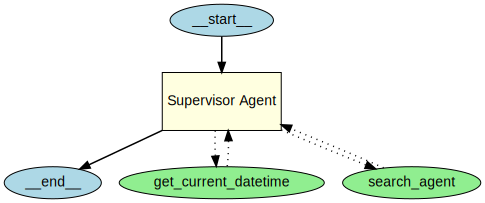

In [15]:
from agents.extensions.visualization import draw_graph

draw_graph(supervisor_agent )

In [13]:
response = Runner.run_sync(supervisor_agent, "What is latest news today with date and time ?")

print(f"**{response.last_agent.name}**:\n\n {response.final_output}")
response.to_input_list()

**Supervisor Agent**:

 Here are some links to major news outlets where you can find the latest news today:

*   **CBS News:** [https://www.cbsnews.com/](https://www.cbsnews.com/)
*   **CNN:** [https://www.cnn.com/](https://www.cnn.com/)
*   **Yahoo News:** [https://news.yahoo.com/](https://news.yahoo.com/)
*   **Fox News:** [https://www.foxnews.com/](https://www.foxnews.com/)
*   **NBC News:** [https://www.nbcnews.com/](https://www.nbcnews.com/)

The current date and time is 2025-05-07 18:23:16.



[{'content': 'What is latest news today with date and time ?', 'role': 'user'},
 {'arguments': '{"input":"latest news today"}',
  'call_id': '',
  'name': 'search_agent',
  'type': 'function_call',
  'id': '__fake_id__'},
 {'arguments': '{}',
  'call_id': '',
  'name': 'get_current_datetime',
  'type': 'function_call',
  'id': '__fake_id__'},
 {'call_id': '',
  'output': 'Here are some links to major news outlets:\n\n*   **CBS News:** [https://www.cbsnews.com/](https://www.cbsnews.com/)\n*   **CNN:** [https://www.cnn.com/](https://www.cnn.com/)\n*   **Yahoo News:** [https://news.yahoo.com/](https://news.yahoo.com/)\n*   **Fox News:** [https://www.foxnews.com/](https://www.foxnews.com/)\n*   **NBC News:** [https://www.nbcnews.com/](https://www.nbcnews.com/)\n\n',
  'type': 'function_call_output'},
 {'call_id': '',
  'output': '2025-05-07 18:23:16',
  'type': 'function_call_output'},
 {'id': '__fake_id__',
  'content': [{'annotations': [],
    'text': 'Here are some links to major news o

In [14]:
# prompt: integrate all cell in one cell

import nest_asyncio
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from google.colab import userdata
from agents import set_tracing_disabled
from agents.tool import function_tool
from tavily import TavilyClient
from datetime import datetime

!pip install -Uq openai-agents tavily-python
nest_asyncio.apply()

gemini_api_key = userdata.get("GEMINI_API_KEY")
search_api_key = userdata.get("SEARCH_API_KEY")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

search_agent_prompt = """
[Your search agent prompt here]
"""

set_tracing_disabled(True)

@function_tool
def browse_online(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=search_api_key)
  response = tavily_client.search(query)
  return response

search_agent = Agent(
    name="Search Agent",
    instructions=search_agent_prompt,
    tools=[browse_online],
    model=model
)

supervisor_prompt = """
[Your supervisor agent prompt here]
"""


@function_tool
def get_current_datetime():
  return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

supervisor_agent_with_datetime = Agent(
    name="Supervisor Agent with Datetime",
    instructions=supervisor_prompt,
    model=model,
    tools=[
        get_current_datetime,
        search_agent.as_tool(tool_name="search_agent",
                             tool_description="Specialized in Searching and Browsing"
                             )
    ]
)

